## 背景介绍

### 线性回归

经典的线性回归模型主要用来预测一些存在着线性关系的数据集。回归模型可以理解为：存在一个点集，用一条曲线去拟合它分布的过程。如果拟合曲线是一条直线，则称为线性回归。如果是一条二次曲线，则被称为二次回归。线性回归是回归模型中最简单的一种。

在线性回归中：

（1）假设函数是指，用数学的方法描述自变量和因变量之间的关系，它们之间可以是一个线性函数或非线性函数。 在本次线性回顾模型中，假设函数为 Y’= wX+b ，其中，Y’表示模型的预测结果（预测房价），用来和真实的Y区分。模型要学习的参数即：w,b。

（2）损失函数是指，用数学的方法衡量假设函数预测结果与真实值之间的误差。这个差距越小预测越准确，而算法的任务就是使这个差距越来越小。 建立模型后，需要给模型一个优化目标，使得学到的参数能够让预测值Y’尽可能地接近真实值Y。这个实值通常用来反映模型误差的大小。不同问题场景下采用不同的损失函数。 对于线性模型来讲，最常用的损失函数就是均方误差（Mean Squared Error， MSE）。

（3）优化算法：神经网络的训练就是调整权重（参数）使得损失函数值尽可能得小，在训练过程中，将损失函数值逐渐收敛，得到一组使得神经网络拟合真实模型的权重（参数）。所以，优化算法的最终目标是找到损失函数的最小值。而这个寻找过程就是不断地微调变量w和b的值，一步一步地试出这个最小值。 常见的优化算法有随机梯度下降法（SGD）、Adam算法等等

### 训练过程

定义好模型结构之后，我们要通过以下几个步骤进行模型训练

1. 初始化参数，其中包括权重ωi和偏置b，对其进行初始化（如0均值，1方差）。
2. 网络正向传播计算网络输出和损失函数。
3. 根据损失函数进行反向误差传播 （backpropagation），将网络误差从输出层依次向前传递, 并更新网络中的参数。
4. 重复2~3步骤，直至网络训练误差达到规定的程度或训练轮次达到设定值。

## Step1:导入必要的包

- paddle.fluid ----> PaddlePaddle 深度学习框架 
- numpy ----> python 基本库，用于科学计算
- matplotlib ----> python 绘图库，可方便绘制折线图、散点图等

In [1]:
import paddle
import paddle.fluid as fluid
import numpy as np
import sys
import math
import matplotlib.pyplot as plt

%matplotlib inline

## Step2: 准备数据

1. uci-housing数据集介绍
    - 数据集共506行,每行14列。前13列用来描述房屋的各种信息，最后一列为该类房屋价格中位数。


2. 读取数据集的接口
    - 训练集 paddle.dataset.uci_housing.train()
    - 测试集 paddle.dataset.uci_housing.test()


3. train_reader和test_reader
    - paddle.reader.shuffle()  表示每次缓存BUF_SIZE个数据项，并进行打乱
    - paddle.batch()  表示每BATCH_SIZE组成一个batch

接下来定义用于训练的数据提供器。提供器每次读入一个大小为BATCH_SIZE的数据批次。如果希望加一些随机性，它可以同时定义一个批次大小和一个缓存大小。这样的话，每次数据提供器会从缓存中随机读取批次大小那么多的数据。

In [2]:
# 定义缓存大小
BUF_SIZE = 500

# 定义批次大小
BATCH_SIZE = 20

In [3]:
# 用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(),
                          buf_size = BUF_SIZE),
    batch_size = BATCH_SIZE)

In [4]:
# 用于测试的数据提供器，每次从缓存中随机读取批次大小的数据
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.test(),
                          buf_size = BUF_SIZE),
    batch_size = BATCH_SIZE)

如果想直接从txt文件中读取数据的话，可以参考以下方式(需要自行准备txt文件)。

In [5]:
"""
feature_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
    'PTRATIO', 'B', 'LSTAT', 'convert'
]
feature_num = len(feature_names)
data = numpy.fromfile(filename, sep=' ') # 从文件中读取原始数据
data = data.reshape(data.shape[0] // feature_num, feature_num)
maximums, minimums, avgs = data.max(axis=0), data.min(axis=0), data.sum(axis=0)/data.shape[0]

for i in six.moves.range(feature_num-1):
   data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i]) # six.moves可以兼容python2和python3

ratio = 0.8 # 训练集和验证集的划分比例
offset = int(data.shape[0]*ratio)
train_data = data[:offset]
test_data = data[offset:]

def reader_creator(train_data):  
    def reader():  
        for d in train_data:  
            yield d[:-1], d[-1:]  
    return reader

train_reader = paddle.batch(
    paddle.reader.shuffle(
        reader_creator(train_data), buf_size=500),
        batch_size=BATCH_SIZE)

test_reader = paddle.batch(
    paddle.reader.shuffle(
        reader_creator(test_data), buf_size=500),
        batch_size=BATCH_SIZE)
"""

"\nfeature_names = [\n    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',\n    'PTRATIO', 'B', 'LSTAT', 'convert'\n]\nfeature_num = len(feature_names)\ndata = numpy.fromfile(filename, sep=' ') # 从文件中读取原始数据\ndata = data.reshape(data.shape[0] // feature_num, feature_num)\nmaximums, minimums, avgs = data.max(axis=0), data.min(axis=0), data.sum(axis=0)/data.shape[0]\n\nfor i in six.moves.range(feature_num-1):\n   data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i]) # six.moves可以兼容python2和python3\n\nratio = 0.8 # 训练集和验证集的划分比例\noffset = int(data.shape[0]*ratio)\ntrain_data = data[:offset]\ntest_data = data[offset:]\n\ndef reader_creator(train_data):  \n    def reader():  \n        for d in train_data:  \n            yield d[:-1], d[-1:]  \n    return reader\n\ntrain_reader = paddle.batch(\n    paddle.reader.shuffle(\n        reader_creator(train_data), buf_size=500),\n        batch_size=BATCH_SIZE)\n\ntest_reader = paddle.batch(\n    paddle.reader.shuffle

4. 打印查看数据
    - PaddlePaddle接口提供的数据已经经过归一化等处理

In [6]:
# 用于打印，查看uci_housing数据
train_data = paddle.dataset.uci_housing.train()
sample_data = next(train_data())
print(sample_data)

(array([-0.0405441 ,  0.06636364, -0.32356227, -0.06916996, -0.03435197,
        0.05563625, -0.03475696,  0.02682186, -0.37171335, -0.21419304,
       -0.33569506,  0.10143217, -0.21172912]), array([24.]))


## Step3: 配置训练程序

### 3.1 网络搭建
训练程序的目的是定义一个训练模型的网络结构。对于线性回归来讲，它就是一个从输入到输出的简单的全连接层。对于波士顿房价数据集，假设属性和房价之间的关系可以被属性间的线性组合描述。

**图片待插入**

In [7]:
# 定义张量变量x和数据类型，表示13维的特征值
x = fluid.layers.data(name = 'x', shape = [13], dtype = 'float32')

In [8]:
# 定义张量y和数据类型,表示目标值
y = fluid.layers.data(name = 'y', shape = [1], dtype = 'float32')

In [9]:
# 定义一个简单的线性网络,连接输入和输出的全连接层
# input:输入tensor;
# size:该层输出单元的数目
# act:激活函数

y_predict = fluid.layers.fc(input = x, size = 1, act = None)

### 3.2 设置主函数
- 参数初始化操作会被写入fluid.default_startup_program()
- fluid.default_main_program()用于获取默认或全局main program(主程序)。该主程序用于训练和测试模型。fluid.layers 中的所有layer函数可以向 default_main_program 中添加算子和变量。
- default_main_program 是fluid的许多编程接口（API）的Program参数的缺省值。例如,当用户program没有传入的时候， Executor.run() 会默认执行 default_main_program 。

In [10]:
# 获取默认/全局主函数
main_program = fluid.default_main_program()

In [11]:
# 获取默认/全局启动程序
startup_program = fluid.default_startup_program()

### 3.3 定义损失函数
- 此处使用均方差损失函数，它会被后面反向传播算法所用到。
- square_error_cost(input,lable)：接受输入预测值和目标值，并返回方差估计，即为$(y-y_{predict})^2$

In [12]:
# 求一个batch的损失值, 利用标签数据和输出的预测数据计算方差
cost = fluid.layers.square_error_cost(input = y_predict, label = y)

In [13]:
# 对方差求均值，得到平均损失
avg_cost = fluid.layers.mean(cost)

### 3.4 设置测试函数

In [14]:
# 克隆main_program得到test_program
# 有些operator在训练和测试之间的操作是不同的，
# 例如batch_norm，使用参数for_test来区分该程序是用来训练还是用来测试
# 该api不会删除任何操作符,请在backward和optimization之前使用

test_program = main_program.clone(for_test=True)

### 3.5 定义优化函数
此处使用的是随机梯度下降。

In [15]:
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)

## Step4: 模型训练和保存

### 4.1 定义训练场所
可以定义运算是发生在CPU还是GPU
- use_cuda为False，表示运算场所为CPU
- use_cuda为True，表示运算场所为GPU 

In [16]:
use_cuda = False

In [17]:
# 指明executor的执行场所
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

### 4.2 创建Executor
- executor可以接受传入的program，并根据feed map(输入映射表)和fetch list(结果获取表)向program中添加数据输入算子和结果获取算子。
- 使用close()关闭该executor
- 调用run(...)执行program

In [18]:
# 创建一个Executor实例exe
exe = fluid.Executor(place)

In [19]:
# Executor的run()方法执行startup_program(),进行参数初始化
exe.run(startup_program)

[]

In [20]:
# 创建一个训练过程中测试用的Executor实例 exe_test
exe_test = fluid.Executor(place)

### 4.3 定义输入数据维度
- DataFeeder负责将数据提供器（train_reader,test_reader）返回的数据转成一种特殊的数据结构，使其可以输入到Executor中。
- feed_list设置向模型输入的向变量表或者变量表名

In [21]:
# 定义输入数据维度
# feed_list:向模型输入的变量表或变量表名
feeder = fluid.DataFeeder(place = place, feed_list = [x, y])

### 4.4 创建训练过程

训练需要有一个训练程序和一些必要参数，并构建一个获取训练过程中测试误差的函数。

#### 4.4.1 构建获取训练过程中测试误差的函数

必要参数有executor,program,reader,feeder,fetch_list。Executor接收传入的program,并根据feed map(输入映射表)和fetch_list(结果获取表) 向program中添加feed operators(数据输入算子)和fetch operators（结果获取算子)。 feed map为该program提供输入数据。fetch_list提供program训练结束后用户预期的变量。
- executor表示之前创建的执行器，接收传入的program；
- program表示执行器所执行的program，是之前创建的program，如果该项参数没有给定的话则默认使用default_main_program；
- reader表示读取到的数据；
- feeder表示前向输入的变量；
- fetch_list表示用户想得到的变量或者命名的结果。

In [22]:
def train_test(executor, program, reader, feeder, fetch_list):
    accumulated = 1 * [0]
    count = 0
    
    for data_test in reader():
        outs = executor.run(program = program,
                           feed = feeder.feed(data_test),
                           fetch_list = fetch_list)
        
        # 累加测试过程中的损失值
        accumulated = [x_c[0] + x_c[1][0] for x_c in zip(accumulated, outs)]
        
        # 累加测试集中的样本数量
        count += 1
        
    # 计算平均损失    
    return [x_d / count for x_d in accumulated]

#### 4.4.2 构建训练主程序

paddlepaddle提供了reader机制来读取训练数据。reader会一次提供多列数据，因此需要一个python的列表来定义读取顺序。构建一个循环来进行训练，直到训练结果足够好或者循环次数足够多。 如果训练迭代次数满足参数保存的迭代次数，可以把训练参数保存到params_dirname。

In [23]:
# 设置Epoch轮数
EPOCH_NUM = 100

注释：
- batch_size：批大小。在深度学习中，一般采用SGD训练，即每次训练在训练集中取batchsize个样本训练；
- iteration：1个iteration等于使用batchsize个样本训练一次；
- epoch：1个epoch等于使用训练集中的全部样本训练一次；

举个例子，训练集有1000个样本，batchsize=10，那么：
训练完整个样本集需要：
100次iteration，1次epoch。

In [24]:
# 设置模型存储目录名
params_dirname = 'fit_a_line.inference.model'

In [25]:
# 设置绘制图形参数
train_prompt = "Train Cost"
test_prompt = "Test Cost"

from paddle.utils.plot import Ploter
plot_prompt = Ploter(train_prompt, test_prompt)

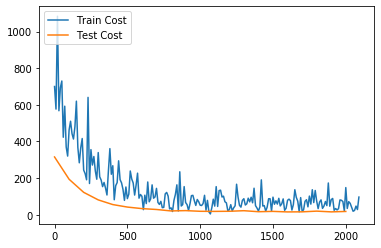

Train Cost, Step 2090, Cost 96.110733


In [26]:
step = 0

# 训练EPOCH_NUM轮
for pass_id in range(EPOCH_NUM):
    
    # 遍历 train_reader 迭代器
    for train_data in train_reader():
        train_cost = exe.run(main_program,                    # 运行主程序
                             # 喂入一个batch的训练数据，根据feed_list和data提供的信息，
                             # 将输入数据转成一种特殊的数据结构
                             feed = feeder.feed(train_data),
                             fetch_list = [avg_cost])
        
        # 每10个批次记录并输出一下训练损失
        if step % 10 == 0:
            plot_prompt.append(train_prompt, step, train_cost[0])
            plot_prompt.plot()
            print("%s, Step %d, Cost %f" %
                  (train_prompt, step, train_cost[0]))
        
        # 每100批次记录并输出一下测试损失
        if step % 100 == 0:
            test_cost = train_test(executor = exe_test,
                                   program = test_program,
                                   reader = test_reader,
                                   feeder = feeder,
                                   fetch_list = [avg_cost]
                                    )
            
            plot_prompt.append(test_prompt, step, test_cost[0])
            plot_prompt.plot()
            print("%s, Step %d, Cost %f" %
                 (test_prompt, step, test_cost[0]))
            
            # 如果准确率达到要求，则停止训练
            if test_cost[0] < 10.0:
                break
        
        step += 1
                
        if math.isnan(float(train_cost[0])):
            sys.exit("Got NaN loss, training failed.")
        
        # 保存训练参数到之前给定的路径中
        if params_dirname is not None:
            fluid.io.save_inference_model(params_dirname,  # 保存model的路径
                                          ['x'],  # 保存建模（inference）需要 feed 的数据
                                          [y_predict],  # 保存建模（inference）结果的 Variables
                                          exe)    # exe 保存 inference model

## Step5: 模型预测

需要构建一个使用训练好的参数来进行预测的程序，训练好的参数位置在`params_dirname`。

### 5.1 准备预测环境

类似于训练过程，预测器需要一个预测程序来做预测。可以稍加修改训练程序来把预测值包含进来。

In [27]:
# 创建预测用的Executor
predict_exe = fluid.Executor(place)

# 创建Scope指定作用域
predict_scope = fluid.core.Scope()

### 5.2 可视化真实值与预测值

In [28]:
def draw_result(ground_truths, predict_results):
    plt.title('Boston Price', fontsize = 24)
    x = np.arange(1, 20)
    y = x
    plt.plot(x, y)
    plt.xlabel('Ground Truth', fontsize = 14)
    plt.ylabel('Predict Result', fontsize = 14)
    plt.scatter(ground_truths, predict_results, color='green', label='training cost')
    plt.grid()
    plt.show()
    plt.savefig('./image/prediction_gt.png')

### 5.3 预测

通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。

In [29]:
ground_truths = []
predict_results = []

# 修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope。
with fluid.scope_guard(predict_scope):
    [predict_program, # 预测的program
     feed_target_names,  # 需要在预测program中提供数据的变量名称
     fetch_targets] = fluid.io.load_inference_model( #fetch_targets: 预测结果
                                    params_dirname, # 模型路径
                                    predict_exe) # 预测用executor
    
    # 获取uci_housing的测试数据，从测试数据中读取一个大小为100的batch数据
    batch_size = 100
    predict_reader = paddle.batch(
        paddle.dataset.uci_housing.test(), batch_size = batch_size)
    
    # 从predict_reader中分割特征和标签
    predict_data = next(predict_reader())
    
    predict_feature = np.array(
        [data[0] for data in predict_data]).astype('float32')
    
    ground_label = np.array(
        [data[1] for data in predict_data]).astype('float32')
    
    assert feed_target_names[0] == 'x'
    
    results = predict_exe.run(predict_program, # 预测模型
                             feed = {feed_target_names[0]: np.array(predict_feature)}, # 喂入要预测的X值
                             fetch_list = fetch_targets) # 获取预测结果
    
    print('Predict Results:')
    for idx, val in enumerate(results[0]):
        print('%d: %.2f' % (idx, val))
        predict_results.append(val)
    
    print('Ground Truth:')
    for idx, val in enumerate(ground_label):
        print('%d: %.2f' % (idx, val))
        ground_truths.append(val)

Predict Results:
0: 14.38
1: 14.62
2: 14.22
3: 16.06
4: 14.77
5: 15.39
6: 14.69
7: 14.50
8: 12.00
9: 14.48
10: 11.44
11: 13.28
12: 14.03
13: 13.54
14: 13.35
15: 14.67
16: 15.97
17: 15.83
18: 16.08
19: 14.18
20: 14.90
21: 13.50
22: 15.49
23: 14.89
24: 14.79
25: 14.08
26: 15.30
27: 15.15
28: 16.24
29: 15.20
30: 14.97
31: 14.35
32: 14.43
33: 13.18
34: 12.81
35: 15.18
36: 15.25
37: 15.82
38: 16.04
39: 15.87
40: 14.42
41: 13.89
42: 15.70
43: 16.08
44: 15.94
45: 15.55
46: 14.68
47: 16.09
48: 16.22
49: 16.62
50: 14.51
51: 14.87
52: 14.28
53: 14.57
54: 15.97
55: 16.56
56: 15.98
57: 16.64
58: 16.79
59: 17.12
60: 17.33
61: 17.12
62: 14.74
63: 15.71
64: 16.57
65: 17.25
66: 16.84
67: 17.21
68: 17.36
69: 17.89
70: 15.78
71: 15.30
72: 16.46
73: 14.81
74: 16.18
75: 16.87
76: 17.97
77: 18.32
78: 18.52
79: 18.27
80: 17.76
81: 18.13
82: 16.99
83: 17.79
84: 16.69
85: 15.71
86: 14.85
87: 16.82
88: 17.65
89: 22.61
90: 22.80
91: 22.52
92: 21.10
93: 22.09
94: 22.44
95: 21.80
96: 22.00
97: 23.39
98: 23.06
99:

In [30]:
draw_result(ground_truths, predict_results)

C:\Users\chenpan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
